## Predicting Auto Claims Severity – Allstate

## 1. Business Understanding
- **Objective:** Predict the final cost (severity) of auto insurance claims using historical claim and vehicle data.  
- A model like this can bring value to Allstate, for example, by
  - Setting reserves to cover claim costs  
  - Routing claims to appropriate adjusters  
  - Identifying key features driving claim costs

# 2. Data Understanding
- **Dataset Overview:**  
  - Each row = a single auto insurance claim  
  - **Label:** `loss` (total paid amount)  
  - Continuous fields are scaled between 0 and 1  
  - Dataset is relatively clean, but **EDA is recommended**  
- **Features:**  
  - **Claim characteristics:** type of accident, time of day, passenger injuries, airbag deployment, highway indicator, report lag, reporter type, etc.  
  - **Vehicle characteristics:** vehicle value, age, year, make/model, etc.  
- **EDA Recommendations:**  
  - Analyze field distributions; detect anomalies, missing values, outliers  
  - Examine categorical feature levels and their population  
  - Compute correlations and visualize univariate relationships between features and the label

## Setup

In [19]:
# Imports
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, zscore

In [5]:
# Upload dataset from google drive
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/MyDrive/claims_data.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# so i am able to see every row and col bc by default outputs are shortened
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## General

In [7]:
df = pd.read_csv(path)
df.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,D,C,B,D,B,A,A,A,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,A,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,B,D,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,D,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,C,B,B,C,A,A,A,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [8]:
df.shape # (188318 claims, 131 features)

(188318, 132)

In [9]:
df.dtypes.value_counts() # 116 categorical features, 15 continuous features, 1 id (int 64)

,count
object,116
float64,15
int64,1


In [10]:
df.isnull().sum() # no null values, good

,0
id,0
cat1,0
cat2,0
cat3,0
cat4,0
cat5,0
cat6,0
cat7,0
cat8,0
cat9,0


In [11]:
min_val    = df['loss'].min()
median_val = df['loss'].median()
p95_val    = df['loss'].quantile(0.95)
max_val    = df['loss'].max()

print(f"Min: {min_val}")
print(f"Median: {median_val}")
print(f"95th Percentile: {p95_val}")
print(f"Max: {max_val}")

Min: 0.67
Median: 2115.5699999999997
95th Percentile: 8508.536499999998
Max: 121012.25


In [12]:
numeric = df.select_dtypes(include='number')

stats = numeric.agg(['mean', 'std']).T
print(stats)

                 mean            std
id      294135.982561  169336.084867
cont1        0.493861       0.187640
cont2        0.507188       0.207202
cont3        0.498918       0.202105
cont4        0.491812       0.211292
cont5        0.487428       0.209027
cont6        0.490945       0.205273
cont7        0.484970       0.178450
cont8        0.486437       0.199370
cont9        0.485506       0.181660
cont10       0.498066       0.185877
cont11       0.493511       0.209737
cont12       0.493150       0.209427
cont13       0.493138       0.212777
cont14       0.495717       0.222488
loss      3037.337686    2904.086186


In [13]:
numeric = df.select_dtypes(include='number')

# Range or std can detect near-constant
stats = numeric.agg(['min', 'max', 'std']).T
print(stats)

# Optionally flag near-constant
near_constant = stats[(stats['std'] < 1e-4) | ((stats['max'] - stats['min']) < 1e-4)]
print("Near-constant features:")
print(near_constant.index.tolist())

             min            max            std
id      1.000000  587633.000000  169336.084867
cont1   0.000016       0.984975       0.187640
cont2   0.001149       0.862654       0.207202
cont3   0.002634       0.944251       0.202105
cont4   0.176921       0.954297       0.211292
cont5   0.281143       0.983674       0.209027
cont6   0.012683       0.997162       0.205273
cont7   0.069503       1.000000       0.178450
cont8   0.236880       0.980200       0.199370
cont9   0.000080       0.995400       0.181660
cont10  0.000000       0.994980       0.185877
cont11  0.035321       0.998742       0.209737
cont12  0.036232       0.998484       0.209427
cont13  0.000228       0.988494       0.212777
cont14  0.179722       0.844848       0.222488
loss    0.670000  121012.250000    2904.086186
Near-constant features:
[]


In [14]:
cont_cols = [c for c in df.columns if df[c].dtype == 'float64' and c != 'loss']
cat_cols = [c for c in df.columns if df[c].dtype == 'object']

## Looking at continuous features

In [15]:
df.describe(include = 'float64')

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


array([[<Axes: title={'center': 'cont1'}>,
        <Axes: title={'center': 'cont2'}>,
        <Axes: title={'center': 'cont3'}>,
        <Axes: title={'center': 'cont4'}>],
       [<Axes: title={'center': 'cont5'}>,
        <Axes: title={'center': 'cont6'}>,
        <Axes: title={'center': 'cont7'}>,
        <Axes: title={'center': 'cont8'}>],
       [<Axes: title={'center': 'cont9'}>,
        <Axes: title={'center': 'cont10'}>,
        <Axes: title={'center': 'cont11'}>,
        <Axes: title={'center': 'cont12'}>],
       [<Axes: title={'center': 'cont13'}>,
        <Axes: title={'center': 'cont14'}>, <Axes: >, <Axes: >]],
      dtype=object)

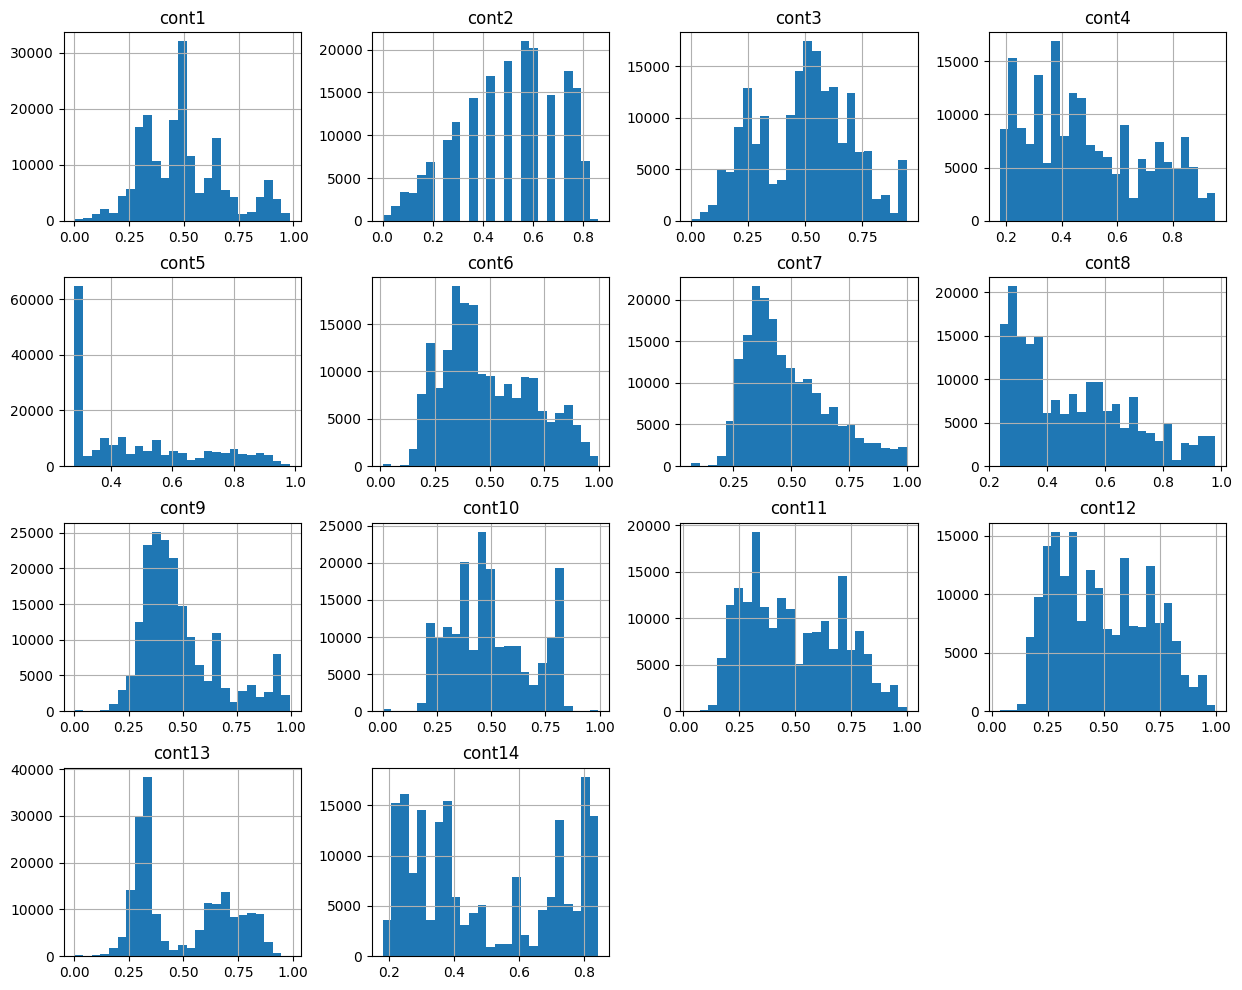

In [16]:
df[cont_cols].hist(figsize=(15, 12), bins = 25)

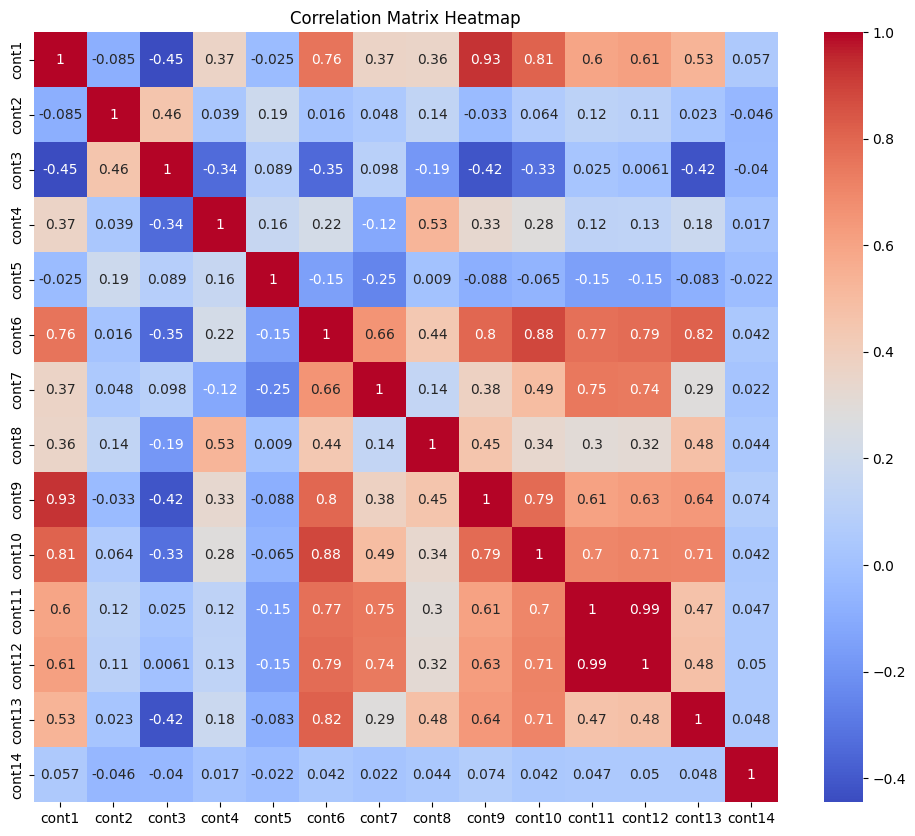

In [17]:
correlation_matrix = df[cont_cols].corr()

# Correlation heatmap for continuous features
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [20]:
z_scores = stats.zscore(df[cont_cols])
outliers_z = (abs(z_scores) > 3)  # 3 std deviations
rows_with_outliers_z = df[outliers_z.any(axis=1)]

print(len(rows_with_outliers_z))

0


In [21]:
(df['loss'] == 0).mean() * 100

np.float64(0.0)

## Looking at categorical features

In [22]:
df[cat_cols].nunique().head()

,0
cat1,2
cat2,2
cat3,2
cat4,2
cat5,2


In [23]:
counts = []

for c in cat_cols:
    vc = df[c].value_counts()
    for cat, count in vc.items():
        counts.append({"feature": c, "category": cat, "count": count})

df_counts = pd.DataFrame(counts)
df_counts.head()

,feature,category,count
0,cat1,A,141550
1,cat1,B,46768
2,cat2,A,106721
3,cat2,B,81597
4,cat3,A,177993


In [24]:
categorical = df.select_dtypes(include='object')  # or 'category' dtype

for col in categorical.columns:
    counts = df[col].value_counts()
    rare = counts[counts < 20]
    if not rare.empty:
        print(f"{col} has rare categories (<20 samples):")
        print(rare)

cat75 has rare categories (<20 samples):
cat75
C    1
Name: count, dtype: int64
cat88 has rare categories (<20 samples):
cat88
B    7
Name: count, dtype: int64
cat89 has rare categories (<20 samples):
cat89
E    5
I    2
H    1
G    1
Name: count, dtype: int64
cat90 has rare categories (<20 samples):
cat90
E    6
F    4
G    2
Name: count, dtype: int64
cat92 has rare categories (<20 samples):
cat92
D    11
F     1
Name: count, dtype: int64
cat96 has rare categories (<20 samples):
cat96
I    12
Name: count, dtype: int64
cat99 has rare categories (<20 samples):
cat99
G    19
O     3
Name: count, dtype: int64
cat101 has rare categories (<20 samples):
cat101
E    7
B    3
K    2
N    1
H    1
U    1
Name: count, dtype: int64
cat102 has rare categories (<20 samples):
cat102
G    15
F    12
H     1
J     1
Name: count, dtype: int64
cat103 has rare categories (<20 samples):
cat103
L    17
K    11
N     2
Name: count, dtype: int64
cat104 has rare categories (<20 samples):
cat104
Q    3
Name: c

## Correlation/Univariate relationship between features and label (loss)

In [25]:
# Continuous columns
cont_cols = [c for c in df.columns if df[c].dtype in ['float64', 'int64'] and c != 'loss']

# Correlation with loss
cont_corr = df[cont_cols + ['loss']].corr()['loss'].drop('loss').sort_values(key=abs, ascending=False)
cont_summary = pd.DataFrame({"feature": cont_corr.index, "corr_with_loss": cont_corr.values})
print("Continuous features correlation with loss:\n")
display(cont_summary)


Continuous features correlation with loss:



,feature,corr_with_loss
0,cont2,0.141528
1,cont7,0.119799
2,cont3,0.111053
3,cont11,0.099806
4,cont12,0.098724
5,cont6,0.040967
6,cont4,-0.035831
7,cont8,0.030508
8,cont10,0.020236
9,cont14,0.019298


# 3. Data Preparation
- Handle remaining missing values, outliers, duplicates  
- Perform transformations if necessary (encoding, normalization already done)  
- Feature engineering if possible (limited due to anonymization)  

In [26]:
df = df.drop(columns = ['id']) # drop id because it's useless

In [27]:
df['log_loss'] = np.log1p(df['loss']) # apply log loss because of crazy outliers

# 4. Modeling
- **Type:** Supervised Learning (Regression)  
- **Library:** TensorFlow/Keras  
- **Target Metric:** Mean Absolute Error (MAE)  


My Version

In [28]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['loss', 'log_loss'])
X = pd.get_dummies(X, drop_first=True)  # categorical -> numerical

y_loss = df['loss']
y_log = df['log_loss']

X_train, X_test, y_loss_train, y_loss_test, y_log_train, y_log_test = train_test_split(
    X, y_loss, y_log, test_size=0.2, random_state=42
)

In [29]:
from sklearn.preprocessing import StandardScaler

# Standardize features (z-scores)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Predicting log_loss
model_log = build_model()
history_log = model_log.fit(
    X_train, y_log_train,
    validation_split=0.2,
    epochs=200,
    batch_size=50,
    callbacks=[early_stop],
    verbose=1
)

# Predicting raw loss
model_raw = build_model()
history_raw = model_raw.fit(
    X_train, y_loss_train,
    validation_split=0.2,
    epochs=200,
    batch_size=50,
    callbacks=[early_stop],
    verbose=1
)
print("Epochs trained (log model):", len(history_log.history['loss']))
print("Epochs trained (raw model):", len(history_raw.history['loss']))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.7729 - mae: 0.9803 - val_loss: 0.4579 - val_mae: 0.5176
Epoch 2/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4277 - mae: 0.5013 - val_loss: 0.4089 - val_mae: 0.4899
Epoch 3/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3823 - mae: 0.4784 - val_loss: 0.3938 - val_mae: 0.4747
Epoch 4/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3510 - mae: 0.4600 - val_loss: 0.4488 - val_mae: 0.4746
Epoch 5/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3410 - mae: 0.4520 - val_loss: 0.4098 - val_mae: 0.4718
Epoch 6/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3267 - mae: 0.4442 - val_loss: 0.4198 - val_mae: 0.4661
Epoch 7/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3165 - mae: 0.4370 - val_loss: 0.4634 - val_mae: 0.4687
Epoch 8/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3091 - mae: 0.4328 - val_loss: 0.4465 - val_mae: 0.4677
Epoch 9/200
2411/2411 ━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 8832091.0000 - mae: 1888.2487 - val_loss: 4574361.0000 - val_mae: 1297.6432
Epoch 2/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4456471.5000 - mae: 1305.1976 - val_loss: 4418506.5000 - val_mae: 1278.1108
Epoch 3/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4371976.5000 - mae: 1271.3448 - val_loss: 4297278.5000 - val_mae: 1265.7450
Epoch 4/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4183370.0000 - mae: 1260.7146 - val_loss: 4123657.2500 - val_mae: 1242.3831
Epoch 5/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3939454.5000 - mae: 1250.1843 - val_loss: 4038112.5000 - val_mae: 1235.5817
Epoch 6/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3839090.7500 - mae: 1228.8251 - val_loss: 4436408.0000 - val_mae: 1256.0563
Epoch 7/200
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3676824.2500 - mae: 1229.0179 - val_loss: 5902202.5000 - val_mae: 1274.7893
Epoch 8/200
2411/2411 ━━━━━

# 5. Evaluation
- **Baseline:** Mean model with MAE = 1970.11  
- Compare model performance against baseline  

In [36]:
from sklearn.metrics import mean_absolute_error

# Predict log-loss
y_pred_log = np.expm1(model_log.predict(X_test))
y_true = y_loss_test  # raw loss true values

# Predict loss directly
y_pred_raw = model_raw.predict(X_test)

# Compute MAE in the same scale (original loss)
mae_log = mean_absolute_error(y_true, y_pred_log)
mae_raw = mean_absolute_error(y_true, y_pred_raw)

print(f"MAE predicting log_loss (converted back): {mae_log:.4f}")
print(f"MAE predicting raw loss directly: {mae_raw:.4f}")

1177/1177 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
MAE predicting log_loss (converted back): 1400.4796
MAE predicting raw loss directly: 1229.9423


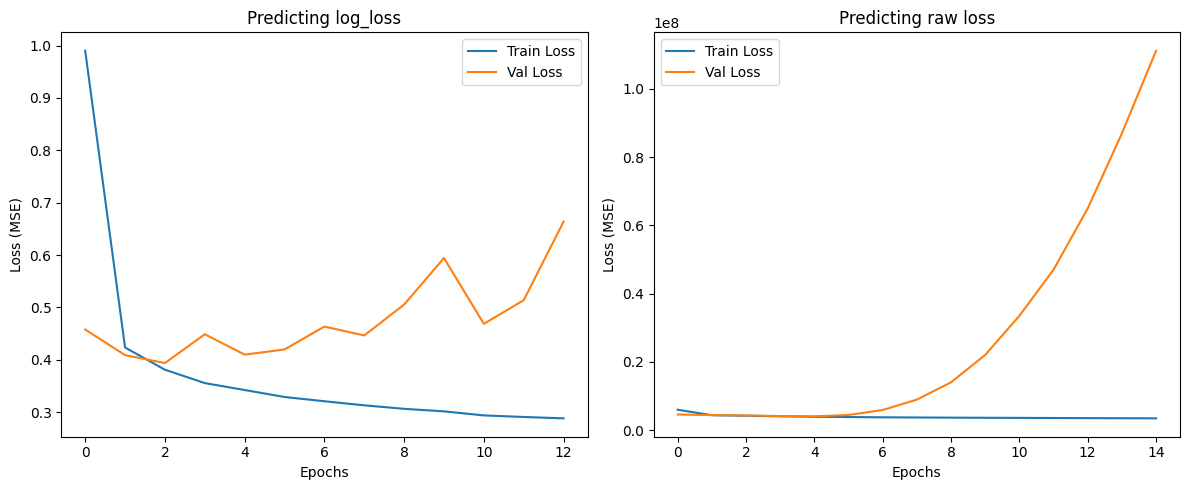

In [37]:
plt.figure(figsize=(12,5))

# Log-loss model
plt.subplot(1,2,1)
plt.plot(history_log.history['loss'], label='Train Loss')
plt.plot(history_log.history['val_loss'], label='Val Loss')
plt.title('Predicting log_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# Raw-loss model
plt.subplot(1,2,2)
plt.plot(history_raw.history['loss'], label='Train Loss')
plt.plot(history_raw.history['val_loss'], label='Val Loss')
plt.title('Predicting raw loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.tight_layout()
plt.show()


# 6. Deployment
<!-- - Predict future claim severity for business decision-making  
- Integrate model into claims processing workflows for routing or reserve estimation -->